<a href="https://colab.research.google.com/github/ptnv-s/Shifts_evaluation_metrics_regression/blob/main/Shifts_evaluation_metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Shifts_evaluation_metrics


## Outline

1. Repository download and Dataset Download
2. Data loading
3. Training & Saving
4. Model loading
5. Evaluation & Inference
6. New Proposed Evaluation Metrics

## 1. Repository Download and Dataset Download




The Github repository with useful scripts is at: [repo](https://github.com/yandex-research/shifts.git)

Data is stored at: [data](https://storage.yandexcloud.net/yandex-research/shifts/weather/canonical-trn-dev-data.tar)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Clone the repository
! git clone https://github.com/yandex-research/shifts

Cloning into 'shifts'...
remote: Enumerating objects: 2409, done.
remote: Counting objects: 100% (657/657), done.
remote: Compressing objects: 100% (231/231), done.
remote: Total 2409 (delta 439), reused 627 (delta 425), pack-reused 1752
Receiving objects: 100% (2409/2409), 10.52 MiB | 23.07 MiB/s, done.
Resolving deltas: 100% (1215/1215), done.


In [3]:
# Add to path
import sys
sys.path.append('../shifts/weather/')

In [4]:
# Download the data. Note, by downloading the data you agree to it's CC BY SA NC 4.0 license!
! wget https://storage.yandexcloud.net/yandex-research/shifts/weather/canonical-trn-dev-data.tar

--2021-10-07 09:33:49--  https://storage.yandexcloud.net/yandex-research/shifts/weather/canonical-trn-dev-data.tar
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5573713920 (5.2G) [application/x-tar]
Saving to: ‘canonical-trn-dev-data.tar’

canonical-trn-dev-d 100%[===================>]   5.19G  20.6MB/s    in 4m 31s  

2021-10-07 09:38:21 (19.6 MB/s) - ‘canonical-trn-dev-data.tar’ saved [5573713920/5573713920]



## 2. Data Loading

All data is provided as csv files. You should have downloaded the following data files:

- `train.csv`
- `dev_in.csv`
- `dev_out.csv`

`dev_in` consists of data in-domain with `train` in terms of time and climate. `dev_out` consists of data shifted in time and climates with respect to `train`.


In [5]:
!mkdir Dataset

In [6]:
import shutil
shutil.unpack_archive("/content/canonical-trn-dev-data.tar", "/content/Dataset/")

In [7]:
import pandas as pd

# Load each data file as a pandas data frame
df_train = pd.read_csv('/content/Dataset/data/train.csv')
df_train.head()

,fact_time,fact_latitude,fact_longitude,fact_temperature,fact_cwsm_class,climate,topography_bathymetry,sun_elevation,climate_temperature,climate_pressure,cmc_0_0_0_1000,cmc_0_0_0_2_grad,cmc_0_0_0_2_interpolated,cmc_0_0_0_2_next,cmc_0_0_0_2,cmc_0_0_0_500,cmc_0_0_0_700,cmc_0_0_0_850,cmc_0_0_0_925,cmc_0_0_6_2,cmc_0_0_7_1000,cmc_0_0_7_2,cmc_0_0_7_500,cmc_0_0_7_700,cmc_0_0_7_850,cmc_0_0_7_925,cmc_0_1_0_0,cmc_0_1_11_0,cmc_0_1_65_0,cmc_0_1_66_0,cmc_0_1_67_0,cmc_0_1_68_0,cmc_0_1_7_0,cmc_0_2_2_10,cmc_0_2_2_1000,cmc_0_2_2_500,cmc_0_2_2_700,cmc_0_2_2_850,cmc_0_2_2_925,cmc_0_2_3_10,...,gfs_temperature_90000,gfs_temperature_92500,gfs_temperature_95000,gfs_temperature_97500,gfs_temperature_sea,gfs_temperature_sea_grad,gfs_temperature_sea_interpolated,gfs_temperature_sea_next,gfs_timedelta_s,gfs_total_clouds_cover_high,gfs_total_clouds_cover_low,gfs_total_clouds_cover_middle,gfs_u_wind,gfs_v_wind,gfs_wind_speed,wrf_available,wrf_t2,wrf_t2_next,wrf_psfc,wrf_rh2,wrf_wind_u,wrf_wind_v,wrf_rain,wrf_snow,wrf_graupel,wrf_hail,wrf_t2_interpolated,wrf_t2_grad,cmc_0_1_65_0_grad,cmc_0_1_65_0_next,cmc_0_1_66_0_grad,cmc_0_1_66_0_next,cmc_0_1_67_0_grad,cmc_0_1_67_0_next,cmc_0_1_68_0_grad,cmc_0_1_68_0_next,gfs_2m_dewpoint_grad,gfs_2m_dewpoint_next,gfs_total_clouds_cover_low_grad,gfs_total_clouds_cover_low_next
0,1.543321e+09,26.968800,-99.248901,2.0,0.0,dry,127.0,-17.526443,14.613571,754.263405,282.702881,6.684790,276.300439,282.985229,276.300439,262.333789,276.962134,280.083057,281.141064,272.500946,14.250,3.750,29.905515,15.500,29.750,15.750,0.0034,0.0,0.00000,0.0,0.0,0.0,0.00000,-1.327548,-2.914091,18.357608,8.480661,-1.510544,-0.465033,-0.126199,...,7.345331,7.926080,8.841516,9.350854,9.077112,1.966156,9.077112,11.043268,0.0,0.0,0.0,0.0,-2.328149,0.509014,2.383144,1.0,280.888000,280.420593,100927.414062,0.623658,-2.533346,-3.091468,0.0,0.0,0.0,0.0,280.888000,-0.467407,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,-2.600006,-2.750006,0.0,0.0
1,1.538776e+09,29.374201,-100.927002,31.0,20.0,mild temperate,297.0,41.531032,26.992143,733.117168,305.860669,-1.361548,303.629541,302.267993,303.629541,267.178882,286.211719,291.642969,298.615479,293.701019,11.500,9.875,22.468424,26.500,1.375,6.250,0.0172,0.0,5.67340,0.0,0.0,0.0,0.00000,-3.568011,-3.632005,4.370947,0.653320,-3.227249,-4.499048,7.287793,...,24.699792,27.050012,29.526605,31.950006,32.831812,-2.257446,32.831812,30.574365,0.0,0.0,23.0,0.0,-3.851841,7.031523,8.017418,1.0,302.893005,303.356781,97645.507812,0.651412,-3.482976,5.238701,0.0,0.0,0.0,0.0,302.893005,0.463776,0.000000,5.673400,0.0,0.0,0.0,0.0,0.0,0.0,-0.600006,17.950006,-12.0,11.0
2,1.552115e+09,22.149599,113.592003,17.0,10.0,mild temperate,-1.0,43.916531,18.842143,761.571076,294.469702,0.282837,295.153361,295.341919,295.059082,268.584375,280.319653,288.922583,292.259375,293.914505,0.750,1.000,25.403430,1.625,2.375,0.125,0.0161,0.0,82.66500,0.0,0.0,0.0,0.00003,0.674461,0.812148,28.046518,20.135425,11.603281,5.047708,1.483844,...,17.325555,18.692010,20.252496,21.868280,23.101434,0.287476,23.197260,23.388910,3600.0,0.0,7.0,0.0,1.512065,4.074417,4.345942,1.0,295.782043,295.726929,100751.773438,0.989764,3.433286,5.181113,0.0,0.0,0.0,0.0,295.782043,-0.055115,0.771400,83.436400,0.0,0.0,0.0,0.0,0.0,0.0,-0.233978,21.450006,1.0,8.0
3,1.549566e+09,34.678699,-86.684799,24.0,20.0,mild temperate,193.0,40.240955,8.303571,747.524910,295.118774,1.091162,296.376611,297.467773,296.376611,262.566675,278.622852,285.923389,290.274927,288.752838,6.125,7.500,5.767445,14.000,4.875,4.125,0.0120,0.0,4.08775,0.0,0.0,0.0,0.00000,2.791129,2.760229,29.527142,25.678796,14.091809,6.503445,6.488293,...,12.791437,13.875513,15.751978,17.743524,19.321313,2.133026,19.321313,21.454340,0.0,21.0,99.0,0.0,2.277510,7.151445,7.505346,1.0,295.235687,296.000824,99450.273438,0.749565,-0.158933,8.494842,0.0,0.0,0.0,0.0,295.235687,0.765137,0.000000,4.087750,0.0,0.0,0.0,0.0,0.0,0.0,0.059448,16.150018,-58.0,41.0
4,1.552910e+09,46.066667,41.966667,9.0,20.0,dry,90.0,30.394660,6.451429,753.168113,28

In [8]:
df_dev_in = pd.read_csv('/content/Dataset/data/dev_in.csv')
df_dev_out = pd.read_csv('/content/Dataset/data/dev_out.csv')

In [9]:
# Visualize the temperature range in the data
def visualize_temperatures(df_list, df_names, plot_type='histogram'):
    '''
    Compare the distribution of temperature labels in datasets

    Supported visualization formats:
     - histogram
     - violin
    '''
    temperatures = np.concatenate([df['fact_temperature'] for df in df_list])
    names = np.concatenate([[name]*len(df) for name, df in zip(df_names, df_list)])
    df_to_plot = pd.DataFrame(data={'Temperature': temperatures, 'Dataset Name':names})

    if plot_type == 'histogram':
        sns.histplot(
            data=df_to_plot, x="Temperature", hue="Dataset Name",
            element="step", stat="density", common_norm=False)
    elif plot_type == 'violin':
        sns.violinplot(x='Temperature', y='Dataset Name',
                              data=df_to_plot, scale='width', palette='Set3')
    else:
        raise ValueError("Unsupported plot_type")
    
    plt.show()
    plt.clf()

In [10]:
df_names = ['train', 'dev_in', 'dev_out']
df_list = [df_train, df_dev_in, df_dev_out]

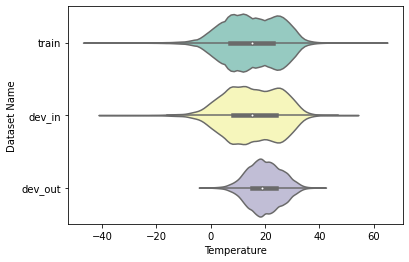

<Figure size 432x288 with 0 Axes>

In [11]:
# Violin Plot
visualize_temperatures(df_list, df_names, plot_type='violin')

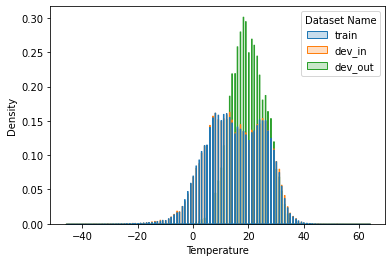

<Figure size 432x288 with 0 Axes>

In [12]:
# Histogram
visualize_temperatures(df_list, df_names, plot_type='histogram')

## 3. Training and Saving

### Training

In this analysis, the `CatBoostRegressor` is used as the model.
- An ensemble of models are trained.
- We use `RMSEWithUncertainty` as the loss function during training time in order to be able to calculate uncertainty measures during inference.
- The models are trained using `df_train` and the hyperparameters should be finetuned using `df_dev_in`.

In [13]:
# Extract features and targets, and remove redundant meta-data
X_train = df_train.iloc[:,6:]
X_dev_in = df_dev_in.iloc[:,6:]
y_train = df_train['fact_temperature']
y_dev_in = df_dev_in['fact_temperature']

In [14]:
# Set training hyperparameters (note these are dummy hyperparameters - you will need to select your own)
ensemble_size = 3
depth = 2
iterations = 200
learning_rate = 0.03

In [15]:
# Train ensemble of models
!pip install catboost
import catboost

trained_models = []
for seed in range(ensemble_size):
    
    model = catboost.CatBoostRegressor(
        learning_rate = learning_rate,
        iterations = iterations,
        depth = depth,
        loss_function = 'RMSEWithUncertainty',
        eval_metric = 'RMSE',
        random_seed = seed)
    
    print(f'\n Model index: {seed}\n')
    
    model.fit(
        X_train,
        y_train,
        verbose = 100,
        eval_set = (X_dev_in, y_dev_in))
    
    trained_models.append(model)

     |████████████████████████████████| 76.4 MB 57 kB/s 

 Model index: 0

0:	learn: 10.0772485	test: 10.0762054	best: 10.0762054 (0)	total: 2.36s	remaining: 7m 49s
100:	learn: 2.8933962	test: 2.8692723	best: 2.8692723 (100)	total: 3m 17s	remaining: 3m 13s
199:	learn: 2.4636227	test: 2.4470545	best: 2.4470545 (199)	total: 6m 9s	remaining: 0us

bestTest = 2.447054531
bestIteration = 199


 Model index: 1

0:	learn: 10.0797424	test: 10.0788222	best: 10.0788222 (0)	total: 2.26s	remaining: 7m 29s
100:	learn: 2.8958509	test: 2.8717422	best: 2.8717422 (100)	total: 3m 11s	remaining: 3m 7s
199:	learn: 2.4668849	test: 2.4504754	best: 2.4504754 (199)	total: 6m	remaining: 0us

bestTest = 2.450475398
bestIteration = 199


 Model index: 2

0:	learn: 10.0766372	test: 10.0755385	best: 10.0755385 (0)	total: 2.31s	remaining: 7m 38s
100:	learn: 2.8947113	test: 2.8704513	best: 2.8704513 (100)	total: 3m 25s	remaining: 3m 21s
199:	learn: 2.4646485	test: 2.4479654	best: 2.4479654 (199)	total: 6m 24s	remaini

### Saving

The trained models are saved below into the current directory. The directory path can be changed to save the models in any preferred location.

In [16]:
dir_path = '.'
for i, model in enumerate(trained_models):
    model.save_model(f'{dir_path}/model{i+1}.cbm')

## 4. Model Loading

### Loading Trained Models

This section assumes that the trained models have been saved in the current directory. The directory path can be altered to point to any location with the trained models.

In [17]:
dir_path = '.'
trained_models = []

# 3 models trained above in this tutorial
ensemble_size=3

for ind in range(1, ensemble_size+1):
    model = catboost.CatBoostRegressor()
    model.load_model(f'{dir_path}/model{ind}.cbm')
    trained_models.append(model)

### Loading Baseline Models

The trained baseline models are provided at: [baseline models](https://storage.yandexcloud.net/yandex-research/shifts/weather/baseline-models.tar)


In [18]:
!mkdir Baseline

In [19]:
# Download baselines
! wget https://storage.yandexcloud.net/yandex-research/shifts/weather/baseline-models.tar

--2021-10-07 10:03:03--  https://storage.yandexcloud.net/yandex-research/shifts/weather/baseline-models.tar
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1243392000 (1.2G) [application/x-tar]
Saving to: ‘baseline-models.tar’

baseline-models.tar 100%[===================>]   1.16G  18.3MB/s    in 60s     

2021-10-07 10:04:04 (19.9 MB/s) - ‘baseline-models.tar’ saved [1243392000/1243392000]



In [ ]:
shutil.unpack_archive("/content/baseline-models.tar", "/content/Baseline/")

In [ ]:
# Loading Trained Baseline Models
# Assume models saved as dir_path/seedi.cbm

dir_path = '/content/Baseline/baseline-models'
baseline_models = []

# 10 models provided
ensemble_size=10

for ind in range(1, ensemble_size+1):
    model = catboost.CatBoostRegressor()
    model.load_model(f'{dir_path}/seed{ind}.cbm')
    baseline_models.append(model)

## 5. Evaluation and Inference

Evaluation and Inference here is shown for the `baseline_models`, but it can be performed in exactly the same manner for the `trained_models`.

All evaluation and inference in this section is carried out on a combined dataset of `dev_in` + `dev_out` = `dev`.
The objective here is two fold:

1. Evaluate the ensemble of trained models to get predictions for each data point
2. Use the predictions to determine an uncertainty score for each data point using any chosen uncertainty measure

It is hoped that the uncertainty measure chosen ensures that data points with greater errors yield greater uncertainties. The uncertainty scores are used to generate retention curves (lowest x% of uncertainties are kept). 

In [ ]:
# Create a combined evaluation dataset and keep only the features
df_dev = pd.concat([df_dev_in, df_dev_out])
X_dev = df_dev.iloc[:,6:]

In [ ]:
# Get ensemble of predictions for each data point

import numpy as np

def get_predictions(features_df, model):
    '''
    Calculates predictions on df features for specified model
    
    Return: array [num_samples x 2],
        where
            num_samples = number of rows in features_df
            2 = [mean, variance]
    
    '''
    return model.predict(features_df)


def get_all_predictions(features_df, models_list):
    '''
    Return: array [ensemble_size x num_samples x 2],
        where
            ensemble_size = number of models in models_list
            num_samples = number of rows in features_df
            2 = [mean, variance]
    '''
    all_preds = []
    for model in models_list:
        preds = np.asarray(get_predictions(features_df, model))
        all_preds.append(preds)
    return np.stack(all_preds, axis=0)


all_preds = get_all_predictions(X_dev, baseline_models)

In [24]:
def entropy_of_expected_class(probs, epsilon=1e-10):
    """
    :param probs: array [num_models, num_examples, num_classes]
    :return: array [num_examples}
    """
    mean_probs = np.mean(probs, axis=0)
    log_probs = -np.log(mean_probs + epsilon)
    return np.sum(mean_probs * log_probs, axis=1)


def expected_entropy_class(probs, epsilon=1e-10):
    """
    :param probs: array [num_models, num_examples, num_classes]
    :return: array [num_examples}
    """
    log_probs = -np.log(probs + epsilon)

    return np.mean(np.sum(probs * log_probs, axis=2), axis=0)


def ensemble_uncertainties_classification(probs, epsilon=1e-10):
    """
    :param probs: array [num_models, num_examples, num_classes]
    :return: Dictionary of uncertaintties
    """
    mean_probs = np.mean(probs, axis=0)
    mean_lprobs = np.mean(np.log(probs + epsilon), axis=0)
    conf = np.max(mean_probs, axis=1)

    eoe = entropy_of_expected_class(probs, epsilon)
    exe = expected_entropy_class(probs, epsilon)

    mutual_info = eoe - exe

    epkl = -np.sum(mean_probs * mean_lprobs, axis=1) - exe

    uncertainty = {'confidence': conf,
                   'entropy_of_expected': eoe,
                   'expected_entropy': exe,
                   'mutual_information': mutual_info,
                   'epkl': epkl,
                   'reverse_mutual_information': epkl - mutual_info
                   }

    return uncertainty


def epkl_reg(preds, epsilon=1e-10):
    """
    preds: array [n_models, n_samples, 2] - mean and var along last axis.
    """
    means = preds[:, :, 0]
    vars = preds[:, :, 1] + epsilon
    logvars = np.log(vars)

    avg_means = np.mean(means, axis=0)
    avg_second_moments = np.mean(means * means + vars, axis=0)

    inv_vars = 1.0 / vars
    avg_inv_vars = np.mean(inv_vars, axis=0)
    mean_inv_var = inv_vars * means
    avg_mean_inv_var = np.mean(mean_inv_var, axis=0)
    avg_mean2_inv_var = np.mean(means * mean_inv_var + logvars, axis=0) + np.log(2 * np.pi)

    epkl = 0.5 * (avg_second_moments * avg_inv_vars - 2 * avg_means * avg_mean_inv_var + avg_mean2_inv_var)

    return epkl


def ensemble_uncertainties_regression(preds):
    """
    preds: array [n_models, n_samples, 2] - last dim is mean, var
    """
    epkl = epkl_reg(preds)

    var_mean = np.var(preds[:, :, 0], axis=0)
    mean_var = np.mean(preds[:, :, 1], axis=0)

    uncertainty = {'tvar': var_mean + mean_var,
                   'mvar': mean_var,
                   'varm': var_mean,
                   'epkl': epkl}

    return uncertainty

In [ ]:
# Choose any uncertainty measure to calculate uncertainty scores
# This tutorial uses total variance as the uncertainty measure
all_uncertainty = ensemble_uncertainties_regression(all_preds)
uncertainties = all_uncertainty['tvar']

### Retention Curves

We plot the retention curves for two different metrics:
1. Mean Squared Error (MSE)
2. F1-score

In each case, the x-axis represents the fraction of data points retained, where the data points are ordered by the chosen uncertainty measure.

In [ ]:
# Get ensemble predictions
all_preds_mean = all_preds[:,:,0]
avg_preds = np.squeeze(np.mean(all_preds_mean, axis=0))

# Get target values
targets = np.asarray(df_dev['fact_temperature'])

# squared error
errors = (avg_preds - targets) ** 2

In [ ]:
from sklearn.metrics import *
from sklearn.utils.multiclass import type_of_target
from sklearn.utils import check_consistent_length, column_or_1d, assert_all_finite
from sklearn.utils.extmath import stable_cumsum


def calc_uncertainty_regection_curve(errors, uncertainty, group_by_uncertainty=True):
    n_objects = errors.shape[0]
    if group_by_uncertainty:
        data = pd.DataFrame(dict(
            errors=errors,
            uncertainty=uncertainty
        ))
        mean_errors = data.groupby("uncertainty").mean()
        mean_errors.rename(columns={"errors": "mean_errors"}, inplace=True)
        data = data.join(mean_errors, "uncertainty")
        data.drop("errors", axis=1, inplace=True)

        uncertainty_order = data["uncertainty"].argsort()
        errors = data["mean_errors"][uncertainty_order]
    else:
        uncertainty_order = uncertainty.argsort()
        errors = errors[uncertainty_order]

    error_rates = np.zeros(n_objects + 1)
    error_rates[:-1] = np.cumsum(errors)[::-1] / n_objects
    return error_rates


assert np.allclose(
    calc_uncertainty_regection_curve(np.array([2, 1]), np.array([1, 0])).mean(),
    2 / 3
)
assert np.allclose(
    calc_uncertainty_regection_curve(np.arange(5), np.array([0, 0, 2, 1, 1])).mean(),
    0.8
)
debug_errors = np.random.rand(10)
assert np.allclose(
    calc_uncertainty_regection_curve(debug_errors, np.zeros_like(debug_errors)).mean(),
    debug_errors.mean() / 2
)


def calc_aucs(errors, uncertainty):
    uncertainty_rejection_curve = calc_uncertainty_regection_curve(errors, uncertainty)
    uncertainty_rejection_auc = uncertainty_rejection_curve.mean()
    random_rejection_auc = uncertainty_rejection_curve[0] / 2
    ideal_rejection_auc = calc_uncertainty_regection_curve(errors, errors).mean()

    rejection_ratio = (uncertainty_rejection_auc - random_rejection_auc) / (
            ideal_rejection_auc - random_rejection_auc) * 100.0
    return rejection_ratio, uncertainty_rejection_auc


def prr_classification(labels, probs, measure, rev: bool):
    if rev:
        measure = -measure
    preds = np.argmax(probs, axis=1)
    errors = (labels != preds).astype("float32")
    return calc_aucs(errors, measure)


def prr_regression(targets, preds, measure):
    preds = np.squeeze(preds)
    # Compute MSE errors
    errors = (preds - targets) ** 2
    return calc_aucs(errors, measure)


def ood_detect(domain_labels, in_measure, out_measure, mode='ROC', pos_label=1):
    scores = np.concatenate((in_measure, out_measure), axis=0)
    scores = np.asarray(scores)
    if pos_label != 1:
        scores *= -1.0

    if mode == 'PR':
        precision, recall, thresholds = precision_recall_curve(domain_labels, scores)
        aupr = auc(recall, precision)
        return aupr

    elif mode == 'ROC':
        roc_auc = roc_auc_score(domain_labels, scores)
        return roc_auc


def nll_regression(target, mu, var, epsilon=1e-8, raw=False):
    nll = (target - mu) ** 2 / (2.0 * var + epsilon) + np.log(var + epsilon) / 2.0 + np.log(2 * np.pi) / 2.0
    if raw:
        return nll
    return np.mean(nll)


def nll_class(target, probs, epsilon=1e-10):
    log_p = -np.log(probs + epsilon)
    return target * log_p[:, 1] + (1 - target) * log_p[:, 0]


def ens_nll_regression(target, preds, epsilon=1e-8, raw=False):
    mu = preds[:, :, 0]
    var = preds[:, :, 1]
    nll = (target - mu) ** 2 / (2.0 * var + epsilon) + np.log(var + epsilon) / 2.0 + np.log(2 * np.pi) / 2.0
    proba = np.exp(-1 * nll)
    if raw:
        return -1 * np.log(np.mean(proba, axis=0))
    return np.mean(-1 * np.log(np.mean(proba, axis=0)))


def calc_rmse(preds, target, raw=False):
    if raw:
        return (preds - target) ** 2
    return np.sqrt(np.mean((preds - target) ** 2))


def ens_rmse(target, preds, epsilon=1e-8, raw=False):
    means = preds[:, :, 0]  # mean values predicted by all models
    avg_mean = np.mean(means, axis=0)  # average predicted mean value
    if raw:
        return calc_rmse(avg_mean, target, raw=True)
    return calc_rmse(avg_mean, target)


def _check_pos_label_consistency(pos_label, y_true):
    # ensure binary classification if pos_label is not specified
    # classes.dtype.kind in ('O', 'U', 'S') is required to avoid
    # triggering a FutureWarning by calling np.array_equal(a, b)
    # when elements in the two arrays are not comparable.
    classes = np.unique(y_true)
    if (pos_label is None and (
            classes.dtype.kind in 'OUS' or
            not (np.array_equal(classes, [0, 1]) or
                 np.array_equal(classes, [-1, 1]) or
                 np.array_equal(classes, [0]) or
                 np.array_equal(classes, [-1]) or
                 np.array_equal(classes, [1])))):
        classes_repr = ", ".join(repr(c) for c in classes)
        raise ValueError(
            f"y_true takes value in {{{classes_repr}}} and pos_label is not "
            f"specified: either make y_true take value in {{0, 1}} or "
            f"{{-1, 1}} or pass pos_label explicitly."
        )
    elif pos_label is None:
        pos_label = 1.0

    return pos_label


def _binary_clf_curve_ret(y_true, y_score, pos_label=None, sample_weight=None):
    # Check to make sure y_true is valid
    y_type = type_of_target(y_true)
    if not (y_type == "binary" or
            (y_type == "multiclass" and pos_label is not None)):
        raise ValueError("{0} format is not supported".format(y_type))

    check_consistent_length(y_true, y_score, sample_weight)
    y_true = column_or_1d(y_true)
    y_score = column_or_1d(y_score)
    assert_all_finite(y_true)
    assert_all_finite(y_score)

    if sample_weight is not None:
        sample_weight = column_or_1d(sample_weight)

    pos_label = _check_pos_label_consistency(pos_label, y_true)

    # make y_true a boolean vector
    y_true = (y_true == pos_label)

    # sort scores and corresponding truth values
    desc_score_indices = np.argsort(y_score, kind="mergesort")[::-1]
    y_score = y_score[desc_score_indices]
    y_true = y_true[desc_score_indices]
    if sample_weight is not None:
        weight = sample_weight[desc_score_indices]
    else:
        weight = 1.

    # y_score typically has many tied values. Here we extract
    # the indices associated with the distinct values. We also
    # concatenate a value for the end of the curve.
    # distinct_value_indices = np.where(np.diff(y_score))[0]
    # threshold_idxs = np.r_[distinct_value_indices, y_true.size - 1]

    # accumulate the true positives with decreasing threshold
    tps = stable_cumsum(y_true * weight)  # [threshold_idxs]
    if sample_weight is not None:
        # express fps as a cumsum to ensure fps is increasing even in
        # the presence of floating point errors
        fps = stable_cumsum((1 - y_true) * weight)  # [threshold_idxs]
    else:
        fps = stable_cumsum((1 - y_true))  # [threshold_idxs]
    return fps, tps, y_score  # [threshold_idxs]


def _precision_recall_curve_retention(y_true, probas_pred, *, pos_label=None,
                                      sample_weight=None):
    fps, tps, thresholds = _binary_clf_curve_ret(y_true, probas_pred,
                                                 pos_label=pos_label,
                                                 sample_weight=sample_weight)

    precision = tps / (tps + fps)
    precision[np.isnan(precision)] = 0
    recall = tps / tps[-1]

    # stop when full recall attained
    # and reverse the outputs so recall is decreasing
    last_ind = tps.searchsorted(tps[-1])
    sl = slice(-1, None, -1)
    return np.r_[precision[sl], 1], np.r_[recall[sl], 0], thresholds[sl]


def _acceptable_error(errors, threshold):
    return np.asarray(errors <= threshold, dtype=np.float32)


def _calc_fbeta_regection_curve(errors, uncertainty, threshold, beta=1.0, group_by_uncertainty=True, eps=1e-10):
    ae = _acceptable_error(errors, threshold)
    pr, rec, _ = _precision_recall_curve_retention(ae, -uncertainty)
    pr = np.asarray(pr)
    rec = np.asarray(rec)
    f_scores = (1 + beta ** 2) * pr * rec / (pr * beta ** 2 + rec + eps)

    return f_scores, pr, rec


def f_beta_metrics(errors, uncertainty, threshold, beta=1.0):
    """

    :param errors: Per sample errors - array [n_samples]
    :param uncertainty: Uncertainties associated with each prediction. rray [n_samples]
    :param threshold: The error threshold below which we consider the prediction acceptable
    :param beta: The beta value for the F_beta metric. Defaults to 1
    :return: fbeta_auc, fbeta_95, retention
    """
    f_scores, pr, rec = _calc_fbeta_regection_curve(errors, uncertainty, threshold, beta)
    ret = np.arange(pr.shape[0]) / pr.shape[0]

    f_auc = auc(ret[::-1], f_scores)
    f95 = f_scores[::-1][np.int(0.95 * pr.shape[0])]

    return f_auc, f95, f_scores[::-1]

In [ ]:
# MSE retention curve
import matplotlib.pyplot as plt

# MSE retention values
rejection_mse = calc_uncertainty_regection_curve(errors, uncertainties)
retention_mse = rejection_mse[::-1]

retention_fractions = np.linspace(0,1,len(retention_mse))

# plot
plt.plot(retention_fractions, retention_mse)
plt.ylabel('MSE')
plt.xlabel("Retention Fraction")
plt.show()
plt.clf()

F1 score at 95% retention:  0.6583114832320486


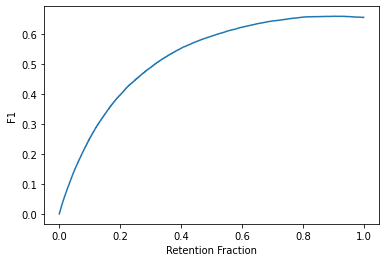

<Figure size 432x288 with 0 Axes>

In [29]:
# F1-score retention curve

# Use an acceptable error threshold of 1 degree
thresh = 1.0

# Get all metrics
f_auc, f95, retention_f1 = f_beta_metrics(errors, uncertainties, thresh, beta=1.0)
print("F1 score at 95% retention: ", f95)

retention_fractions = np.linspace(0,1,len(retention_f1))

# plot
plt.plot(retention_fractions, retention_f1)
plt.ylabel('F1')
plt.xlabel("Retention Fraction")
plt.show()
plt.clf()

## 6. New Proposed Evaluation Metrics

### Log-Loss Fisher Uncertainity


####Calculating LL-FU for ensmble model


In [30]:
def LL_FU_Ensmble(preds, errors):
  means = np.mean(preds[:,:,0],axis=0)
  vars  = np.mean(preds[:,:,1],axis=0)
  print(vars.shape)
  fi = 0
  fi_list = []
  for i in range(vars.shape[0]):
    fi = max((0.5*np.log10(2*np.pi*vars[i])),0.0) + (errors[i]/(2*vars[i]))
    fi_list.append(fi)
  #fisher_info = -0.5*np.log(2*np.pi*vars) - ((errors)/2*vars)
  return fi_list

In [31]:
uncertainties_ens = np.array(LL_FU_Ensmble(all_preds, errors))

(100000,)


In [32]:
errors_sin = (all_preds[0,:,0] - targets) ** 2

####Calculating LL-FU for single model


In [33]:
def LL_FU_Single(preds, errors):
  means = preds[0,:,0]
  vars  = preds[0,:,1]
  fi = 0
  fi_list = []
  for i in range(vars.shape[0]):
    fi = max((0.5*np.log10(2*np.pi*vars[i])),0.0) + (errors[i]/(2*vars[i]))
    fi_list.append(fi)
  #fisher_info = -0.5*np.log(2*np.pi*vars) - ((errors)/2*vars)
  return fi_list

In [34]:
uncertainties_sin = np.array(LL_FU_Single(all_preds, errors_sin))


####Plotting F1-retention curve for ensmble and single models for an acceptable prediction

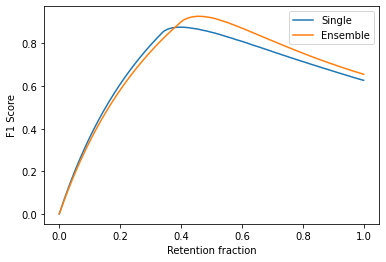

In [35]:
# F1-score retention curve

# Use an acceptable error threshold of 1 degree
thresh = 1.0

# Get all metrics
f_auce, f95, retention_f1_ens = f_beta_metrics(errors, uncertainties_ens, thresh, beta=1.0)
retention_fractions = np.linspace(0,1,len(retention_f1_ens))
f_aucs, f95, retention_f1_single = f_beta_metrics(errors_sin, uncertainties_sin, thresh, beta=1.0)
plt.plot(retention_fractions, retention_f1_single)
plt.plot(retention_fractions, retention_f1_ens)
plt.ylabel('F1 Score')
plt.xlabel("Retention fraction")
s='Single'
e='Ensemble'
plt.legend([s,e])
plt.savefig("ll-fu", dpi=80)

In [36]:
uncertaintiesmv = all_uncertainty['mvar']
# Predictions are the mean predictions across the ensemble of models
preds = np.mean(all_preds[:,:,0], axis=0)
df_submission = pd.DataFrame(data={
        'PRED' : preds,
        'UNCERTAINTY' : uncertainties,
        'Errors' : errors,
        'Errors_S' : errors_sin,
        'LLFU_ENS' : uncertainties_ens,
        'LLFU_S' : uncertainties_sin,
        'target' : targets,
        'mvar' : uncertaintiesmv,
        })

####Plotting LLFU-error scatter plot

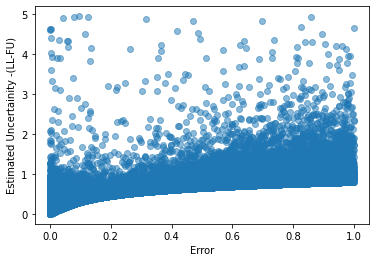

In [37]:
df2 = df_submission[df_submission['Errors']<=1.0]
df20 = df2[df2['LLFU_ENS']<5]
plt.scatter(df20['Errors'],df20['LLFU_ENS'],alpha=0.5)
plt.ylabel('Estimated Uncertainity -(LL-FU)')
plt.xlabel('Error')
plt.show()

####Plotting Uncertainty-error scatter plot for LL-FU and mvar uncertainity metrics

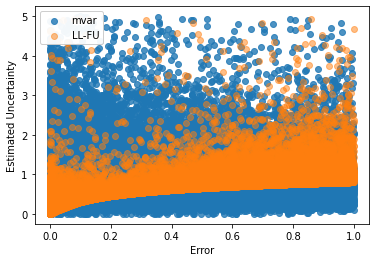

In [38]:
df2 = df_submission[df_submission['Errors']<=1.0]
df21 = df2[df2['mvar']<5]
df20 = df2[df2['LLFU_ENS']<5]
plt.scatter(df21['Errors'],df21['mvar'],alpha=0.8)
plt.scatter(df20['Errors'],df20['LLFU_ENS'],alpha=0.5)
plt.ylabel('Estimated Uncertainty')
plt.xlabel('Error')
s='mvar'
e='LL-FU'
plt.legend([s,e], loc='upper left',framealpha=0.95)
plt.show()